# Imports

In [1]:
!pwd
import shutil
import os

from molgroups.support import molstat
from molgroups.infotheory import entropy

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_singlethread/refl1d


# Create Short Example Fit

A functional fit needs to be provided loading simX.dat data files. Currently, the information theory package requires all parameters to be defined using the Parameter() method, and names should not contain spaces. Solvent nSLDs need to be named rho_solv_X to allow the correct background scattering to be calculated.

In [2]:
%%writefile ssblm.py
## === Import section ===
import sys
# append path to your molgroups, or just link molgroups to your same directory
import numpy as np
from molgroups import mol
from molgroups import lipids
from molgroups import components as cmp
from refl1d.names import load4, Parameter, SLD, Slab, Stack, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

## === Film structure definition section ===

### Bilayer profile definition function

def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, l_submembrane, l_lipid1, l_lipid2, vf_bilayer):
    """ Fairly generic bilayer. This assumes a stack of materials already existing because siox.l is set to zero """
    
    # Set unused parameters
    l_siox = 0.0 # could make a parameter in the future
    rho_siox = 0.0

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, global_rough=global_rough, rho_substrate=rho_substrate, rho_siox=rho_siox, l_siox=l_siox,
              l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)
    
    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # Return nSLD profile in Refl1D units
    return nsld*1e6

### Define bilayer parameters
vf_bilayer = Parameter(name='volume_fraction_bilayer', value=0.9).range(0.0, 1.0)
l_lipid1 = Parameter(name='inner_acyl_chain_thickness', value=10.0).range(8, 16)
l_lipid2 = Parameter(name='outer_acyl_chain_thickness', value=10.0).range(8, 16)
sigma = Parameter(name='bilayer_roughness', value=5).range(2, 9)
global_rough = Parameter(name ='tiox_roughness', value=5).range(2, 9)
l_tiox = Parameter(name='total_tiox_thickness', value=120).range(50, 150)
l_submembrane = Parameter(name='submembrane_thickness', value=10).range(0, 50)

### Define bilayer object
blm = mol.ssBLM(lipids=[lipids.DOPC], lipid_nf=[1.0])

### Define molgroups space.
dimension=300       # Number of steps
stepsize=0.5        # Length of steps

## === Stack ===
##
## First, we create a 'material' for each bulk layer, which has an real and imaginary
## scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
tiox = SLD(name='tiox', rho=2.1630, irho=0.0000)
siox = SLD(name='siox', rho=4.1000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)

## Then bulk layers are created, each with its own 'material'.  If you want to force
## two layers to always match SLD you can use the same material in multiple layers.
## The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=5.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=5.0000)
layer_tiox = Slab(material=tiox, thickness=l_tiox - (blm.substrate.z + 0.5 * blm.substrate.l), interface=0.0)
layer_siox = Slab(material=siox, thickness=7.5804, interface=10.000)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=0.0000)

## Set sample parameter ranges and constraints between layer properties
# layer roughness parameters
###################################################################
## the 'interface' associated with layer0 is the boundary between #
## layer0 and layer1, and similarly for layer(N) and layer(N+1)   #
###################################################################
layer_siox.interface = siox_interface = Parameter(name='siox_interface', value=5.0).range(2.0000, 9.000)

# Si and SiOx roughnesses are the same
layer_silicon.interface = layer_siox.interface

# nSLD parameters
d2o.rho = rho_d2o = Parameter(name='rho_solv_0', value=6.34).range(5.3000, 6.5000)
h2o.rho = rho_h2o = Parameter(name='rho_solv_1', value=-0.56).range(-0.6, 0.6)
tiox.rho = rho_tiox = Parameter(name='rho_tiox', value=2).range(1.1630, 3.1630)
siox.rho = rho_siox = Parameter(name='rho_siox', value=3.5).range(3.1000, 5.1000)

# layer thickness parameters
layer_tiox.thickness = tiox_thickness = Parameter(name='tiox_thickness', value=100.).range(66.379, 266.38)
layer_siox.thickness = siox_thickness = Parameter(name='siox_thickness', value=30.).range(5, 40)

## Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
## Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=d2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)
mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma,
                                bulknsld=h2o.rho, global_rough=global_rough, rho_substrate=tiox.rho,
                                l_submembrane=l_submembrane, l_lipid1=l_lipid1, l_lipid2=l_lipid2,
                                vf_bilayer=vf_bilayer)

## Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
## As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate side,
## set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | layer_tiox | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | layer_tiox | mollayerh | layer_h2o

## === Data files ===
probe = load4('sim0.dat', back_reflectivity=True)
probeh = load4('sim1.dat', back_reflectivity=True)

# Set instrumental (probe) parameters
probe.background = background_0 = Parameter(name='background_0', value=0.).range(-1e-7, 1e-5)
probeh.background = background_1 = Parameter(name='background_1', value=0.).range(-1e-7, 1e-5)
probe.intensity = intensity = Parameter(name='intensity', value=1.0).range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset = theta_offset = Parameter(name='theta_offset', value=0.).range(-0.015, 0.005)
probeh.theta_offset = probe.theta_offset
probe.sample_broadening = sample_broadening = Parameter(name='sample_broadening', value=0).range(-0.005, 0.02)
probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it
# probe.critical_edge(substrate=silicon, surface=d2o)

## === Problem definition ===
## a model object consists of a sample and a probe.

## step = True corresponds to a calculation of the reflectivity from an actual profile
## with microslabbed interfaces.  When step = False, the Nevot-Croce
## approximation is used to account for roughness.  This approximation speeds up
## the calculation tremendously, and is reasonably accuarate as long as the
## roughness is much less than the layer thickness
step = False

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)

problem = FitProblem([model, modelh])

## === Export objects for post analysis ===
problem.name = "DOPC bilayer on TiOx substrate"
problem.bilayers = [blm]
problem.dimension = dimension
problem.stepsize = stepsize


Overwriting ssblm.py


# -p /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_singlethread/refl1d/ssblm.py --fit=dream --parallel --init=lhs --store=T --burn=20 --steps=5 --overwrite --seed=181954
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 0 in [-1e-07,1e-05]
  .intensity = 1 in [0.9,1.05]
  .sample_broadening = 0 in [-0.005,0.02]
  .theta_offset = 0 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 5 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 5 in [2,9]
      .material
        .irho = siox irho = 0
        .rho = rho_siox = 3.5 in [3.1,5.1]
      .thickness = siox_thickness = 30 in [5,40]
    [2]
      .interface = tiox interface = 0
      .material
        .irho = tiox irho = 0
        .rho = rho_tiox = 2 

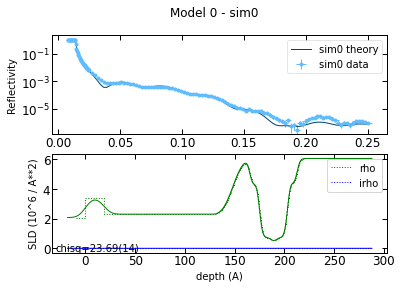

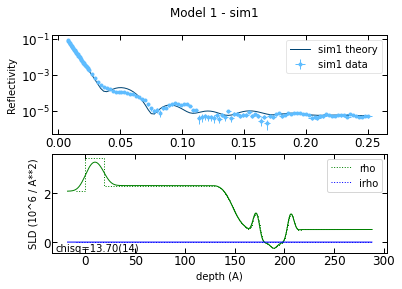

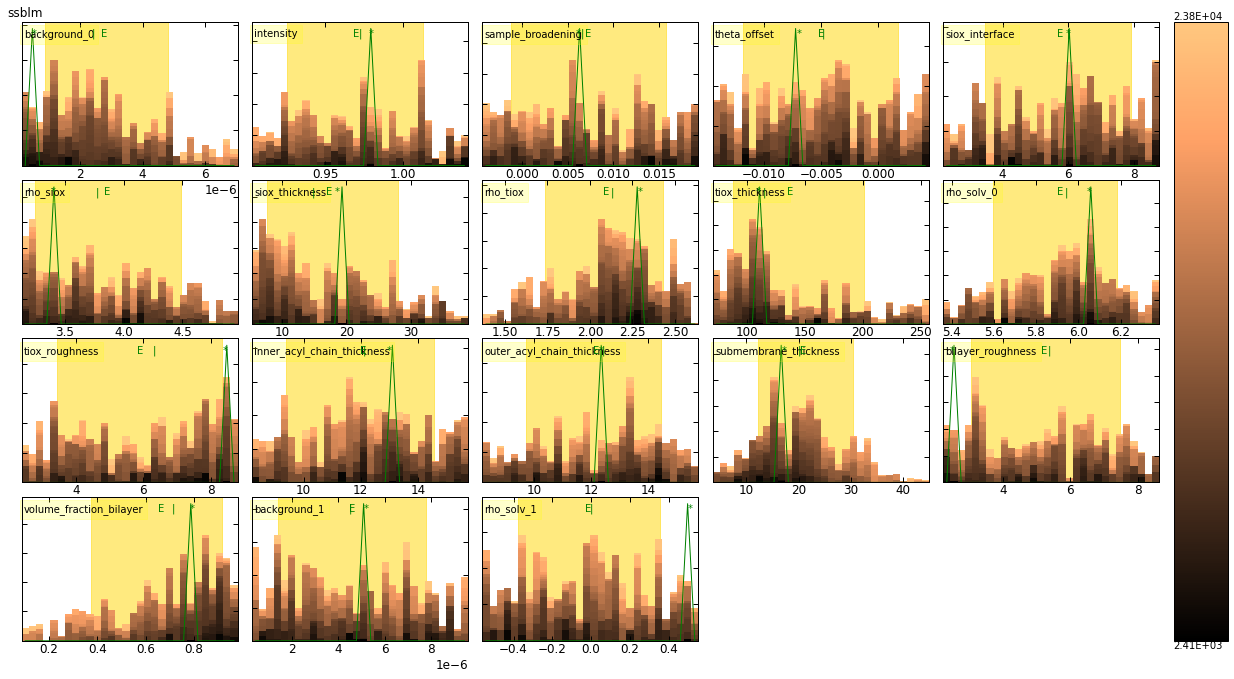

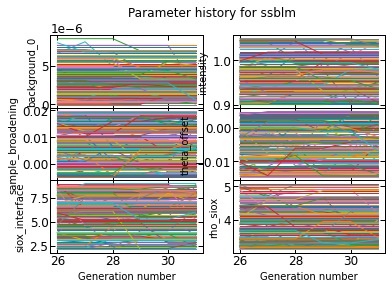

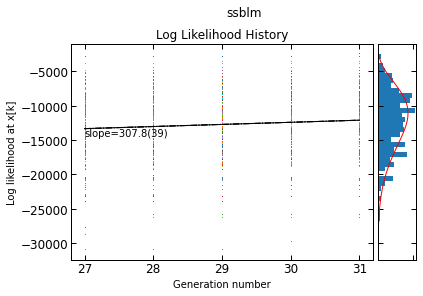

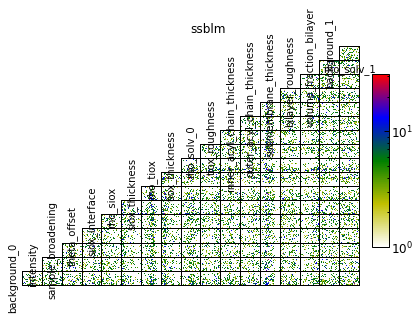

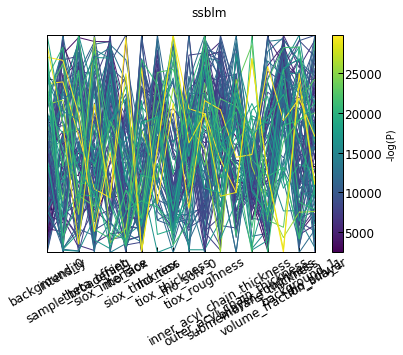

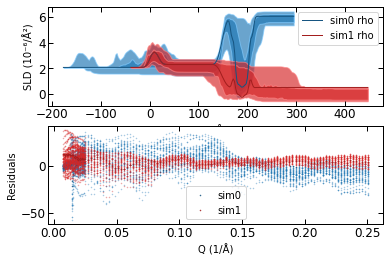

In [3]:
shutil.copyfile('ch060.refl', 'sim1.dat')
shutil.copyfile('ch061.refl', 'sim0.dat')

setupdir = os.getcwd()
store = "T"
runfile = "ssblm"
fitsource = "refl1d"
if not os.path.isdir(store):
    os.mkdir(store)
burn = 20
steps = 5

fit_object = molstat.CMolStat(fitsource=fitsource, spath=setupdir, mcmcpath=store, runfile=runfile, state=None, problem=None)
fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

# Defining Optimization Parameters in entropypar.dat

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries. 
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step). 
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* Any theta offset currently needs to have an initial value of zero. Otherwise refl1d will shift the q-values during data simulation with unexpected outcomes.

In [5]:
from refl1d import main
sys.argv = ['-p', os.path.join(setupdir, runfile)+'.py', '--fit=dream', '--init=lhs', '--store=T', '--steps=10', '--burn=10', '--overwrite']
main.cli()
#fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

# -p /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_singlethread/refl1d/ssblm.py --fit=dream --init=lhs --store=T --steps=10 --burn=10 --overwrite --seed=377693
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 0 in [-1e-07,1e-05]
  .intensity = 1 in [0.9,1.05]
  .sample_broadening = 0 in [-0.005,0.02]
  .theta_offset = 0 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interface = siox_interface = 5 in [2,9]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox_interface = 5 in [2,9]
      .material
        .irho = siox irho = 0
        .rho = rho_siox = 3.5 in [3.1,5.1]
      .thickness = siox_thickness = 30 in [5,40]
    [2]
      .interface = tiox interface = 0
      .material
        .irho = tiox irho = 0
        .rho = rho_tiox = 2 in [1.163,

AttributeError: type object 'Path' has no attribute '_flavour'

<Figure size 432x288 with 0 Axes>

In [4]:
%%writefile entropypar.dat
i background_0 1.03489e-06 -1e-07 1e-05
i intensity 1.0 0.9 1.05
i sample_broadening 0 -0.005 0.02
i theta_offset 0.0 -0.015 0.005
i siox_interface 6.85069 2 9
i rho_siox 3.39556 3.1 5.1
i siox_thickness 14.9832 5 40
i rho_tiox 2.32129 1.163 3.163 -1 10 1
i tiox_thickness 110.913 66.379 266.38
i tiox_roughness 6.8149 2 9
d inner_acyl_chain_thickness 11.1605 8 16
d outer_acyl_chain_thickness 13.6487 8 16
d submembrane_thickness 13.9116 0 50
d bilayer_roughness 4.84472 2 9
d volume_fraction_bilayer 0.906858 0 1
i rho_solv_0 6.21572 5.3 6.5
i background_1 3.95582e-06 -1e-07 1e-05
i rho_solv_1 -0.550133 -0.6 0.6
n prefactor 2.58496

Overwriting entropypar.dat


# Variables

In [5]:
# general fit setup
setupdir = os.getcwd()
runfile = "ssblm"
store = 'T'
fitsource = "refl1d"

# particular entropy setup
burn = 4000
steps = 200
convergence = 2.0
miniter = 1
mode = 'water'
bClusterMode = False
bFetchMode = False
time = 2
bcalcsymmetric = True
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = []
script.append('#!/bin/bash\n')
script.append('#SBATCH --job-name=entro {mcmc_iteration}\n')
script.append('#SBATCH -A mc4s9np\n')
script.append('#SBATCH -p RM\n')
script.append('#SBATCH -t 0' + str(time) + ':00:00\n')
script.append('#SBATCH -N 4\n')
script.append('#SBATCH --ntasks-per-node 28\n')
script.append('\n')
script.append('set +x\n')
script.append('cd $SLURM_SUBMIT_DIR\n')
# script.append('cd '+dirname+'\n')
script.append('\n')
script.append('module load python/2.7.11_gcc\n')
script.append('export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n')
script.append('\n')
script.append('mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time=' 
              + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn) 
              + ' --steps=' + str(steps) + '\n')


# Fit Setup

In [6]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn, 
    mcmcsteps=steps, 
    convergence=convergence, 
    miniter=miniter, 
    mode=mode,                      
    bClusterMode=bClusterMode, 
    bFetchMode=bFetchMode, 
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel, 
    plotlimits_filename=plotlimits_filename,
    slurmscript=script
)

In [7]:
entr.run_optimization()

background_0 1.03489e-06
intensity 1.0
sample_broadening 0.0
theta_offset 0.0
siox_interface 6.85069
rho_siox 3.39556
siox_thickness 14.9832
rho_tiox -1.0
tiox_thickness 110.913
rho_solv_0 6.21572
tiox_roughness 6.8149
inner_acyl_chain_thickness 11.1605
outer_acyl_chain_thickness 13.6487
submembrane_thickness 13.9116
bilayer_roughness 4.84472
volume_fraction_bilayer 0.906858
background_1 3.95582e-06
rho_solv_1 -0.550133
# -p /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_singlethread/refl1d/iteration_0/ssblm.py --fit=dream --parallel --init=lhs --batch --store=save --burn=4000 --steps=200 --overwrite --seed=271262
-- Model 0 sim0
.probe
  .back_absorption = back_absorption sim0 = 1
  .background = background_0 = 4.95e-06 in [-1e-07,1e-05]
  .intensity = 0.975 in [0.9,1.05]
  .sample_broadening = 0.0075 in [-0.005,0.02]
  .theta_offset = -0.005 in [-0.015,0.005]
.sample
  .layers
    [0]
      .interf

ValueError: Pool not running

In [ ]:
entr.plot_results()

In [ ]:
for M in entr.molstat.Interactor.problem.models:
    print(dir(M))
    print(M.fitness.reflectivity())

In [ ]:
entr.molstat.Interactor.problem._parameters